# Extractive QA



1. Scraping Dell Website (Data Collection)
1. Cleaning dataset
1. QA Fromatting using Haystack Annotation tool (SQUAD format)
1. Tokenisation, DocumentStore (FAISS, InMemoryDocumentStore), Retriever (DPR), Reader (FARMReader)

# Scraping

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import uuid
import os
from tqdm import tqdm

import time
from selenium import webdriver
# for headless
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import json

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36'}



# url = 'https://www.dell.com/community/PowerEdge-Hardware-General/PowerEdge-R730XD-Loading-BIOS-Drivers/m-p/7644944#M65318'
url = 'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW'
r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.text, 'html.parser')

print(soup.title.text)


	PowerEdge Hardware General - Dell Community



### Dell Website: Scraping for URLs

- For this project will exclusivley look at Hardware Dell suppport forums, we could later incorporate other fields such as Software issues and label entries as such. But for now, focusing on Hardware `https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW`.
- 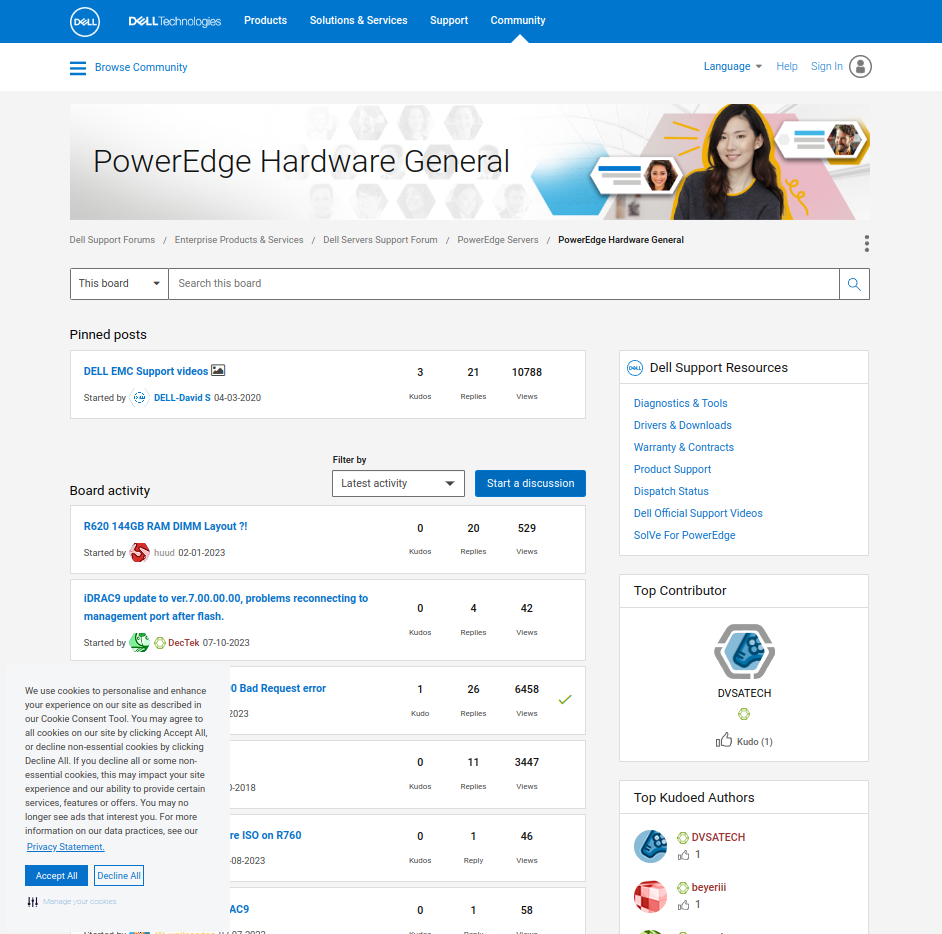
- We want to land on the website and pull `URLs` of Solved Dell forum posts and save them as a list (search for HTML elements `//a[@href]`.
- As this internet network is based in **EU**, there is a `Accept Cookies` button that can pop up when the webpage is first openedthat needs to be clicked.
- Using the Selium library, will first filter by `Solved` cases in order to scrape forums that have a solution (using Chrome Developer tool helps identify the HTML element names):
- 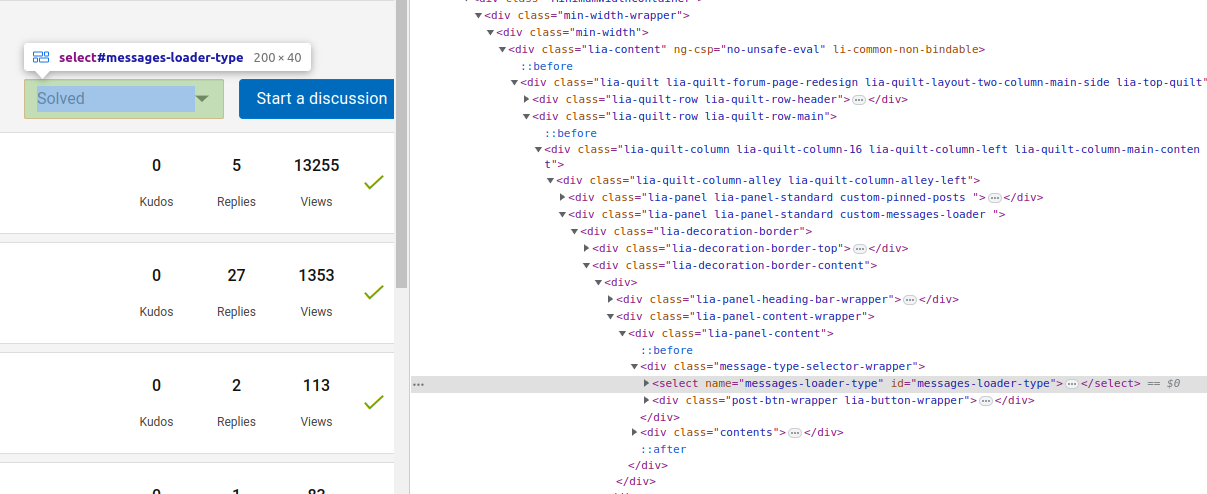
- After Solved button will need to scroll down to `Load More`. Note a `MoveTargetOutOfBoundsException` error can occur when the scroll action goes beyond the bounds of the webpage. To avoid this error, we can try a different approach by scrolling to the bottom of the page using `execute_script()` and then clicking the "Load more" button. The parameter `num_clicks` which indicates the number of times to click the "Load more" button.

> One issue, as we click Load More, the website length increases until eventually we cant scroll down to the bottom fast enough in order to click Load More again. As we increase `num_clicks` to be `>90` we hit an error because we are not giving the function enough time, using `time.sleep()`, to scroll down the increasingly larger webpage `ElementClickInterceptedException`. To resolve this we scroll the element into view using the `execute_script` method. This ensures that the element is visible and clickable (`driver.execute_script("arguments[0].scrollIntoView();", load_more_button)
`). 



In [41]:
def automate_dell_forum(num_clicks):
    # Instantiate the Selenium web driver
    driver = webdriver.Chrome()
    driver.maximize_window()  # Maximize the browser window

    # Navigate to the Dell community forum page
    driver.get('https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW')

    # Press the "Accept All" button for cookies
    accept_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//a[@aria-label="allow cookies"]')))
    accept_button.click()
    
    # Select the "Solved" option from the dropdown
    select_element = driver.find_element(By.ID, 'messages-loader-type')
    option_solved = select_element.find_element(By.XPATH, "//option[@value='solved']")
    option_solved.click()

    # Wait for the page to load after selecting "Solved" option
    time.sleep(2)

    # Scroll to the bottom of the page
    print("scrolled outside loop")
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait for a few seconds BEFORE clicking the "Load more" button
    print("wait(2) outside before loop")
    time.sleep(2)
    

    # Click the "Load more" button the specified number of times
    count = 1
    
    for _ in range(num_clicks):
        load_more_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'btn-load-more')))
        print("Waiting... for a few seconds BEFORE clicking the Load more button")
        time.sleep(3)
        print("Wait befor done")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        print("scrolled in loop at", count)
        time.sleep(3)
        print("waited 2 secs after scroll")
        load_more_button.click()
        count += 1
        print("clicked: ", count)
        print("Waiting... for a few seconds AFTER clicking the Load more button")
        time.sleep(6)
        print("Wait after done")
    
        
    
    # Wait for the page to load AFTER clicking "Load more" button
    #print("Waiting... for a few seconds AFTER clicking the Load more button")
    print("wait(2) outside after loop")

    time.sleep(2)
    
    #print("Wait after done")
    

    # Get all href urls on the page and save them to a list
    urls = driver.find_elements(By.XPATH, '//a[@href]')
    url_list = [url.get_attribute('href') for url in urls]

    # Close the Selenium web driver
    driver.quit()

    return url_list

# Call the method to automate the process and get the url list, num_of_clicks=
url_list = automate_dell_forum(189)

# Print the urls (forum posts)
#for url in url_list:
#    print(url)

scrolled outside loop
wait(2) outside before loop
Waiting... for a few seconds BEFORE clicking the Load more button
Wait befor done
scrolled in loop at 1
waited 2 secs after scroll
clicked:  2
Waiting... for a few seconds AFTER clicking the Load more button
Wait after done
Waiting... for a few seconds BEFORE clicking the Load more button
Wait befor done
scrolled in loop at 2
waited 2 secs after scroll
clicked:  3
Waiting... for a few seconds AFTER clicking the Load more button
Wait after done
Waiting... for a few seconds BEFORE clicking the Load more button
Wait befor done
scrolled in loop at 3
waited 2 secs after scroll
clicked:  4
Waiting... for a few seconds AFTER clicking the Load more button
Wait after done
Waiting... for a few seconds BEFORE clicking the Load more button
Wait befor done
scrolled in loop at 4
waited 2 secs after scroll
clicked:  5
Waiting... for a few seconds AFTER clicking the Load more button
Wait after done
Waiting... for a few seconds BEFORE clicking the Load 

In [42]:
import csv

with open('list_189.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(url_list)

In [43]:
with open('list_189.txt', 'w') as file:
    for item in url_list:
        file.write(str(item) + '\n')

In [44]:
len(url_list) #189

7675

In [26]:
len(url_list)

3713

In [ ]:
clicked_200 = url_list[:]

In [27]:

clicked_90 = url_list[:]



In [ ]:
len(clicked_90)

In [18]:
len(execute_script_10)

113

In [14]:
len(clicked__urls_60)

2513

In this updated version, the waiting time after clicking the "Load more" button is dynamically increased by adding a fraction (0.5 seconds) of the current click count (count) to the base waiting time of 3 seconds. This ensures that the waiting time increases as more clicks are made, allowing the webpage to load fully before attempting to click again. Adjust the fraction (0.5) as needed based on your observations of the webpage loading time.

### Dell Website: Filter  and clean URLs

- 

In [45]:
def filtered_urls(url_list):
    filtered_urls = []
    exclude_urls = [
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW#',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/custom.dell.link.solutions.href',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/custom.dell.link.careers.href',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/custom.dell.link.about.href',
        'https://www.dell.com/community/PowerEdge-Hardware-General/bd-p/PowerEdge-General-HW'
    ]
    for url in url_list:
        if url.startswith('https://www.dell.com/community/PowerEdge-Hardware-General/') and url not in exclude_urls:
            filtered_urls.append(url)
    return filtered_urls

# Filter the urls
filtered_urls = filtered_urls(url_list)

In [46]:
len(filtered_urls)

1901

### Dell website: Visit forum post and pull Answers, Question text and URLs linking to Support documents (Context)

- We want to structure the dataset as Question (the forum query asked by a user), Answer (The community agreed solution) and importantly what we will be calling Context (the text pulled from a linked suppporting artcile). But the website stricture is a little messy, but after some trial and error was able to identify that:
    - The first `lia-message-body-content` always references the Question
    - The second `lia-message-body-content` is always the pinned answer (for "Solved" forum posts)
    - So we will simple combine and save the first `lia-message-body-content` into Questions and the second into Answers
    - Any refered to `https://` in the Answer to be saved for later use as Context.
- 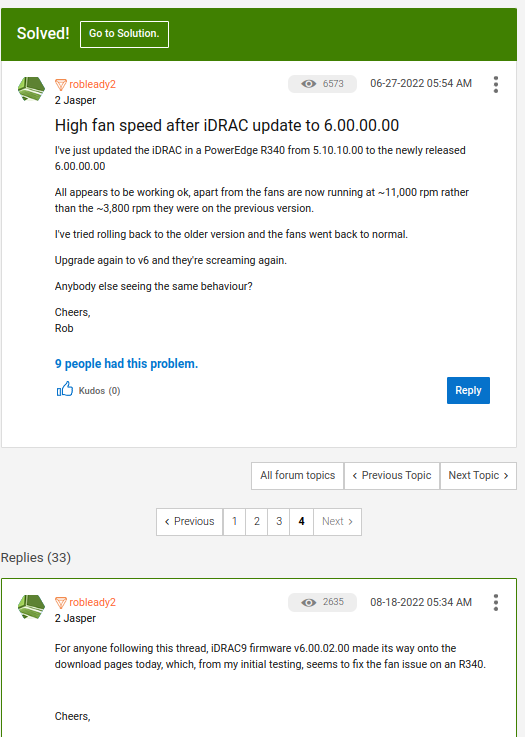

To speed up the `extract_elements_with_class` function and incorporate tqdm for a progress bar, you can make the following modifications:

1. Use `tqdm` to create a progress bar: Import the `tqdm` module and wrap the `urls` list with `tqdm` to create a progress bar that shows the status of the extraction process.

2. Utilize `Session` object from the `requests` module: Instead of creating a new `requests` session for each URL, you can use a `Session` object to take advantage of connection pooling and improve performance.

3. Use `find` instead of `find_all`: Since you only need the first two elements with the specified class name, you can use `find` instead of `find_all` to improve performance.

Here's the modified code:

```python
from tqdm import tqdm
import requests
import pandas as pd
from bs4 import BeautifulSoup

def extract_elements_with_class(urls, class_name):
    elements_list = []
    session = requests.Session()
    for url in tqdm(urls, desc="Extracting elements"):
        try:
            response = session.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            elements = soup.find_all(class_=class_name, limit=2)  # Limit to the first two elements
            for element in elements:
                elements_list.append(element.text.strip())
            for _ in range(2 - len(elements)):
                elements_list.append("")  # Append empty strings if elements are not found
        except requests.exceptions.RequestException:
            elements_list.extend(["", ""])  # Append empty strings if there's an error
    return elements_list

class_name = "lia-message-body-content"
extracted_elements = extract_elements_with_class(filtered_urls, class_name)

# Ensure extracted_elements has an even number of elements
if len(extracted_elements) % 2 != 0:
    extracted_elements.append("")  # Append an empty string to make it even

# Split the extracted elements into Questions and Answers lists
Questions = extracted_elements[::2]
Answers = extracted_elements[1::2]

# Create a dataframe called QA
QA = pd.DataFrame({"Questions": Questions, "Answers": Answers})
```

In the modified code, `tqdm` is used to create a progress bar that shows the status of the extraction process. The `requests.Session()` object is created outside the loop to take advantage of connection pooling. Additionally, `find_all` is limited to the first two elements (`limit=2`), and the empty strings are appended using a loop to ensure there are always two elements for each URL.

These modifications should improve the speed of the function and provide a progress bar using `tqdm` to monitor the extraction process.

In [47]:
from tqdm import tqdm
import requests
import pandas as pd
from bs4 import BeautifulSoup

def extract_elements_with_class(urls, class_name):
    elements_list = []
    session = requests.Session()
    for url in tqdm(urls, desc="Extracting elements"):
        try:
            response = session.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            elements = soup.find_all(class_=class_name, limit=2)  # Limit to the first two elements
            for element in elements:
                elements_list.append(element.text.strip())
            for _ in range(2 - len(elements)):
                elements_list.append("")  # Append empty strings if elements are not found
        except requests.exceptions.RequestException:
            elements_list.extend(["", ""])  # Append empty strings if there's an error
    return elements_list

class_name = "lia-message-body-content"
extracted_elements = extract_elements_with_class(filtered_urls, class_name)

# Ensure extracted_elements has an even number of elements
if len(extracted_elements) % 2 != 0:
    extracted_elements.append("")  # Append an empty string to make it even

# Split the extracted elements into Questions and Answers lists
Questions = extracted_elements[::2]
Answers = extracted_elements[1::2]

# Create a dataframe called QA
QA_large = pd.DataFrame({"Questions": Questions, "Answers": Answers})

Extracting elements: 100%|██████████| 1901/1901 [54:27<00:00,  1.72s/it] 


In [48]:
QA_large.head()

,Questions,Answers
0,"We provide you a variety of support related videos on our DELL EMC Support YouTube channel. We publish at least one new video every week so make sure you subscribe and stay up to date with the latest turoials, tipps and tricks about server, storage and networking.\n \nHere are some playlist you might find helpful for your daily business regarding DELL EMC Enterprise hardware.\n\nOpenManage Server Administrator \nRAID - Tutorials, Information and Troubleshooting \nDell EMC QuickTips - something about everything \niDRAC - Setup, Configuration, Troubleshooting \nDell Lifecycle Controller \nSupportAssist Enterprise Virtual Edition \n\nYou can find the full list here.\n \nSomething is missing? Got a topic we should cover in one of our videos? Feel free to suggest new topics and give us feedback to existing ones in this thread.","Hi All,\nthere are 2 new videos up on the channel. As always a Quick Tip Video on Service Tag locations and in addition we show you how to install OMSA on ESXi 6.7\nAnd don't forget to like the videos and subscribe to our channel for all the latest updates!"
1,"Hello,We were asked by DELL supporter to update iDRAC again for a hardware support, from 6.02.00.00 to 6.10.00.00. After updating, the secure web access to iDRAC failed with error:Bad RequestYour browser sent a request that this server could not understand.Additionally, a 400 Bad Request error was encountered while trying to use an ErrorDocument to handle the request.After doing some tests, I have the following conclusions/workarounds:1. the secure web access failed when using the FQDN of iDRAC interface2. using the IP or short hostname works with the secure web access3. setting iDRAC.WebServer.ManualDNSEntry to have the FQDN included won't solve the issue4. disabling idrac.webserver.HostHeaderCheck aslo works, but could not open virtual console viewer I tried to use racadm command 'sslresetcfg' to regenerate the certificate, but only short hostname used as Common Name (CN) and also only the short hostname listed in the DNS alternative name. By the way, we have DNS BMC/RAC Name and DNS Domain name correctly configured.It looks like to me a new bug in version 6.10.00.00. Though there are not issues with the IP and short hostname access, it is still annoying since we have FQDN defined and linked everywhere. Thanks,Di\n\n\n\n\t\t\t\t\t\n\t\t\t\t\t\tSolved!\n\t\t\t\t\t\n\t\t\t\t\tGo to Solution.","Indeed, this seems fixed in later version. I just updated one of our nodes to version 6.10.80.00, the issue described in my first post has gone. When I was testing iDRAC version 6.10.30.00, the issue was sill there.\n\n\nView solution in original post"
2,"After a long power outage, the accountant decided to turn on the server on her own.After pressing the button ""i"" and holding it for a little longer, she reset the settings iDRAC along with the license.How can I restore it now? The server was purchased in 2014. Service Tag <Service Tag was removed>.\n \n\n\n\n\t\t\t\t\t\n\t\t\t\t\t\tSolved!\n\t\t\t\t\t\n\t\t\t\t\tGo to Solution.","Hi, Sergei 66,\n \niDRAC license was sent to you.\n \nPlease ask me if you have any questions, \n \nThank you,\nMaria Januszka\n#IWork4Dell\nDell | Social Outreach Services - Enterprise\n\nMaria JSocial Media and Communities Professional Dell Technologies | Enterprise Support Services #Iwork4Dell Did I answer your query? Please click on ‘Accept as Solution’‘Kudo’ the posts you like!\n\n\n\nView solution in original post"
3,"Hi Dell Team,We are currently experiencing an issue with the ServiceTag on our Dell server. When attempting to enter the tag on Dell's website, an error message stating ""Service Tag or Product ID Search Error"" is displayed. could you please advise? Best regards!\n\n\n\n\t\t\t\t\t\n\t\t\t\t\t\tSolved!\n\t\t\t\t\t\n\t\t\t\t\tGo to Solution.","It works now, Thank you so much Young E.Have a great day.\n\n\nView solution in original post"
4,"Hello! I want to perform a memory upgrade on my R6515

In [7]:
# import


# Read the CSV file into a DataFrame
QA_large = pd.read_csv("QA_large_cleaned.csv")

In [6]:
# export
QA_large.to_csv('QA_large_cleaned.csv', index=False)

NameError: name 'QA_large' is not defined

### Data Cleaning

In [8]:
# Set pandas options to display all columns and rows without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [9]:
# Create a new dataframe for cleaned data
QA_cleaned = QA_large.copy()

# Clean up the "Questions" and "Answers" columns
QA_cleaned['Questions'] = QA_cleaned['Questions'].str.replace('Go to Solution', '').str.replace('Solved!', '')
QA_cleaned['Questions'] = QA_cleaned['Questions'].str.replace('\n', '').str.replace('\t', '').str.replace('IWork4Dell', '')
QA_cleaned['Questions'] = QA_cleaned['Questions'].str.replace("Did I answer your query? Please click on ‘Accept as Solution’. ‘Kudo’ the posts you like!", '')

QA_cleaned['Answers'] = QA_cleaned['Answers'].str.replace("Did I answer your query? Please click on ‘Accept as Solution’. ‘Kudo’ the posts you like!", '')
QA_cleaned['Answers'] = QA_cleaned['Answers'].str.replace("View solution in original post", '')
QA_cleaned['Answers'] = QA_cleaned['Answers'].str.replace('\n', '').str.replace('\t', '').str.replace('#IWork4Dell', '')


/tmp/ipykernel_6694/3290180330.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  QA_cleaned['Questions'] = QA_cleaned['Questions'].str.replace("Did I answer your query? Please click on ‘Accept as Solution’. ‘Kudo’ the posts you like!", '')
/tmp/ipykernel_6694/3290180330.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  QA_cleaned['Answers'] = QA_cleaned['Answers'].str.replace("Did I answer your query? Please click on ‘Accept as Solution’. ‘Kudo’ the posts you like!", '')


In [34]:
# export
QA_cleaned.to_csv('QA_cleaned.csv', index=False)

In [10]:
QA_cleaned.head()

,Questions,Answers
0,"We provide you a variety of support related videos on our DELL EMC Support YouTube channel. We publish at least one new video every week so make sure you subscribe and stay up to date with the latest turoials, tipps and tricks about server, storage and networking. Here are some playlist you might find helpful for your daily business regarding DELL EMC Enterprise hardware.OpenManage Server Administrator RAID - Tutorials, Information and Troubleshooting Dell EMC QuickTips - something about everything iDRAC - Setup, Configuration, Troubleshooting Dell Lifecycle Controller SupportAssist Enterprise Virtual Edition You can find the full list here. Something is missing? Got a topic we should cover in one of our videos? Feel free to suggest new topics and give us feedback to existing ones in this thread.","Hi All,there are 2 new videos up on the channel. As always a Quick Tip Video on Service Tag locations and in addition we show you how to install OMSA on ESXi 6.7And don't forget to like the videos and subscribe to our channel for all the latest updates!"
1,"Hello,We were asked by DELL supporter to update iDRAC again for a hardware support, from 6.02.00.00 to 6.10.00.00. After updating, the secure web access to iDRAC failed with error:Bad RequestYour browser sent a request that this server could not understand.Additionally, a 400 Bad Request error was encountered while trying to use an ErrorDocument to handle the request.After doing some tests, I have the following conclusions/workarounds:1. the secure web access failed when using the FQDN of iDRAC interface2. using the IP or short hostname works with the secure web access3. setting iDRAC.WebServer.ManualDNSEntry to have the FQDN included won't solve the issue4. disabling idrac.webserver.HostHeaderCheck aslo works, but could not open virtual console viewer I tried to use racadm command 'sslresetcfg' to regenerate the certificate, but only short hostname used as Common Name (CN) and also only the short hostname listed in the DNS alternative name. By the way, we have DNS BMC/RAC Name and DNS Domain name correctly configured.It looks like to me a new bug in version 6.10.00.00. Though there are not issues with the IP and short hostname access, it is still annoying since we have FQDN defined and linked everywhere. Thanks,Di.","Indeed, this seems fixed in later version. I just updated one of our nodes to version 6.10.80.00, the issue described in my first post has gone. When I was testing iDRAC version 6.10.30.00, the issue was sill there."
2,"After a long power outage, the accountant decided to turn on the server on her own.After pressing the button ""i"" and holding it for a little longer, she reset the settings iDRAC along with the license.How can I restore it now? The server was purchased in 2014. Service Tag <Service Tag was removed>. .","Hi, Sergei 66, iDRAC license was sent to you. Please ask me if you have any questions, Thank you,Maria JanuszkaDell | Social Outreach Services - EnterpriseMaria JSocial Media and Communities Professional Dell Technologies | Enterprise Support Services #Iwork4Dell Did I answer your query? Please click on ‘Accept as Solution’‘Kudo’ the posts you like!"
3,"Hi Dell Team,We are currently experiencing an issue with the ServiceTag on our Dell server. When attempting to enter the tag on Dell's website, an error message stating ""Service Tag or Product ID Search Error"" is displayed. could you please advise? Best regards!.","It works now, Thank you so much Young E.Have a great day."
4,"Hello! I want to perform a memory upgrade on my R6515 server.Currently the server has 16x32GB DDR4-2400 RDIMMI bought 16x64GB DDR4-2400 LRDIMM. After the memory upgrade the server only contained these LRDIMM memory modules and nothing was mixed. They were the same brand, speed, type and so just like before.The issue I'm having is that when trying to boot the server with the new memory it doesn't get past the ""Please wait while system is initializing"". It

### Contexts

In [11]:
# Read the CSV file into a DataFrame 
QA_large = pd.read_csv("QA_cleaned.csv")

# Convert the 'Answers' column to string type
QA_large['Answers'] = QA_large['Answers'].astype(str)

# Extract links using regular expression and handle non-string values
QA_large['Context_url'] = QA_large['Answers'].apply(lambda x: re.findall('https://[\S]+', x) if isinstance(x, str) else [])

# Convert the list of links into a single string separated by commas
QA_large['Context_url'] = QA_large['Context_url'].apply(lambda x: ', '.join(x) if x else '')

# Create a new DataFrame called 'QA_docs' with selected columns
QA_docs_v2 = QA_large[['Questions', 'Answers', 'Context_url']].copy()

In [12]:
QA_docs_v2.tail(10)

,Questions,Answers,Context_url
901,"I have 2x Dell R610 servers. One proceeds quickly through POST while the other drops into ""Collecting System Inventory"" for about 10 mins before booting.Is there a way to disable the ""collecting system inventory"" on every boot?.","Usao,Yes there is a way to disable Collecting System Inventory on Restart (CSIOR).Access the iDRAC6 Configuration Utility by pressing <CTRL+E> during POST.Select System Services from the main menu.Change the Collect System Inventory on Restart setting to Disabled.See a similar screen shot below:Let me know if you have any further questions",
902,"Hi, Team I have a poweredge T410 with intel E5620 on CPU 1. It runs great but I want to upgrade to XEON X5675 on both CPU slots. I purchase two X5675 and I specifically told them to make sure that they work in tandem both have same specs but different S#s. they work separately fine on CPU one on CPU 2 it halts at boot and give me a message in RED letter to move the chip to CPU1. Order Memory from memory netM393B2G70BH0-YH9Samsung 1x 16GB DDR3-1333 RDIMM PC3L-10600R Dual Rank x4 ModuleBios ver 1.14.0I have followed the poweredge T410 technical guide about memory configuration but nothing. Computer will not Boot up.Help please..",you can find here the updated list of processorhttps://dell.to/32FXYevpage 25Marco B.Social Media and Communities Professional Dell Technologies | Enterprise Support ServicesDid I answer your query? Please click on ‘Accept as Solution’. ‘Kudo’ the posts you like!,https://dell.to/32FXYevpage
903,Server would not power on. Dell tech came and replaced the backplane and PER620 card and then left. The server will now power on but will not boot the existing volume or virtual drive. The server is remote to us and I’m guessing and hoping it’s a simple configuration issue with the new controller but how did the Dell tech know if they didn't see it boot up? The folks on site said the POST does recognize the 1 virtual drive. But it does not boot up. They tried to boot using the BIOS and the UEFI options.Is it something simple like setting the virtual drive as bootable? I thought that some controllers could read the config from the disks?I was hoping there was maybe a tech note on getting the system to boot after replacing the back plane and or PER620 controller..,I looked at the original specs and there was an SD card and Internal Dual SD Module.342-3595 : 1GB SD Card for RIPS331-4441 : Internal Dual SD Module318-2036 : vFlash SD Slot Filler The folks on site took a look and the SD card was popped out or not seated. With the SD card pushed back in the BIOS now sees the SD card and boots from it.,
904,"Hi All,I currently have two Dell Power Edge R720 servers. Both servers have redundant 1100W AC power supplies. Two weeks ago a power outage caused one power supply of each server to malfunction which were replaced under warranty by new power supplies. Since then the PS2 socket of both servers have been reporting an error, VLT0204 System board PS2 PG Fail voltage is outside of range. Contact support.In order to solve the problem I powered off the system and disconnected the power cords and pressed the power button. I then swapped the power supplies re-connected the power cords and powered on the system. I repeated this step for the second server. Both the systems now did not report the VLT0204 error. However, the 'VLT0204 System board PS2 PG Fail voltage is outside of range. Contact support.' error message appeared on the front panel again. Repeating the steps above did not resolve the issue. I realised that this time the VLT0204 error became persistent. Just to be sure that the error is persistent I cleared the hardware logs after which I can still see a critical error in the iDRAC Server Health -> Voltages section.I used the DSET to generate the server report logs which too shows the VLT0204 error message. I can provide the entire zip file if needed.Should I ignore this error message or should I send it to D

In [13]:
QA_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Questions    911 non-null    object
 1   Answers      911 non-null    object
 2   Context_url  911 non-null    object
dtypes: object(3)
memory usage: 21.5+ KB


### Labeling Data with Haystack Annotation Tool


https://www.deepset.ai/blog/labeling-data-with-haystack-annotation-tool


- 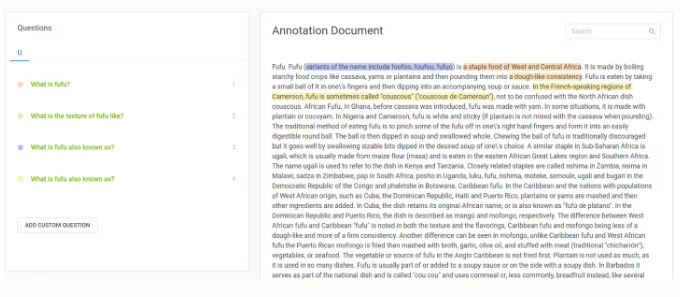




Please use comma separated `CSVs` and include the header in the first line. You might also want to wrap text around quotation marks, e.g. if it contains commas. We always use pandas to_csv method, this should format the file in the right way.

```
docs.csv:
document_identifier,document_text
id1,bbbbb
id2,muh
```
the same holds for the questions.csv:
```
question,document_identifier,question_identifier
question1,id1,qid1
question2,id2,qid2

```


Lets take a subset to test with

### only use rows with URLs

QA_con = QA_large[df['Context_url'].notna()]


In [18]:
QA_con = QA_large[QA_large['Context_url'].notna()]

In [23]:
QA_con.head()

,Questions,Answers,Context_url
0,"We provide you a variety of support related videos on our DELL EMC Support YouTube channel. We publish at least one new video every week so make sure you subscribe and stay up to date with the latest turoials, tipps and tricks about server, storage and networking. Here are some playlist you might find helpful for your daily business regarding DELL EMC Enterprise hardware.OpenManage Server Administrator RAID - Tutorials, Information and Troubleshooting Dell EMC QuickTips - something about everything iDRAC - Setup, Configuration, Troubleshooting Dell Lifecycle Controller SupportAssist Enterprise Virtual Edition You can find the full list here. Something is missing? Got a topic we should cover in one of our videos? Feel free to suggest new topics and give us feedback to existing ones in this thread.","Hi All,there are 2 new videos up on the channel. As always a Quick Tip Video on Service Tag locations and in addition we show you how to install OMSA on ESXi 6.7And don't forget to like the videos and subscribe to our channel for all the latest updates!",
1,"Hello,We were asked by DELL supporter to update iDRAC again for a hardware support, from 6.02.00.00 to 6.10.00.00. After updating, the secure web access to iDRAC failed with error:Bad RequestYour browser sent a request that this server could not understand.Additionally, a 400 Bad Request error was encountered while trying to use an ErrorDocument to handle the request.After doing some tests, I have the following conclusions/workarounds:1. the secure web access failed when using the FQDN of iDRAC interface2. using the IP or short hostname works with the secure web access3. setting iDRAC.WebServer.ManualDNSEntry to have the FQDN included won't solve the issue4. disabling idrac.webserver.HostHeaderCheck aslo works, but could not open virtual console viewer I tried to use racadm command 'sslresetcfg' to regenerate the certificate, but only short hostname used as Common Name (CN) and also only the short hostname listed in the DNS alternative name. By the way, we have DNS BMC/RAC Name and DNS Domain name correctly configured.It looks like to me a new bug in version 6.10.00.00. Though there are not issues with the IP and short hostname access, it is still annoying since we have FQDN defined and linked everywhere. Thanks,Di.","Indeed, this seems fixed in later version. I just updated one of our nodes to version 6.10.80.00, the issue described in my first post has gone. When I was testing iDRAC version 6.10.30.00, the issue was sill there.",
2,"After a long power outage, the accountant decided to turn on the server on her own.After pressing the button ""i"" and holding it for a little longer, she reset the settings iDRAC along with the license.How can I restore it now? The server was purchased in 2014. Service Tag <Service Tag was removed>. .","Hi, Sergei 66, iDRAC license was sent to you. Please ask me if you have any questions, Thank you,Maria JanuszkaDell | Social Outreach Services - EnterpriseMaria JSocial Media and Communities Professional Dell Technologies | Enterprise Support Services #Iwork4Dell Did I answer your query? Please click on ‘Accept as Solution’‘Kudo’ the posts you like!",
3,"Hi Dell Team,We are currently experiencing an issue with the ServiceTag on our Dell server. When attempting to enter the tag on Dell's website, an error message stating ""Service Tag or Product ID Search Error"" is displayed. could you please advise? Best regards!.","It works now, Thank you so much Young E.Have a great day.",
4,"Hello! I want to perform a memory upgrade on my R6515 server.Currently the server has 16x32GB DDR4-2400 RDIMMI bought 16x64GB DDR4-2400 LRDIMM. After the memory upgrade the server only contained these LRDIMM memory modules and nothing was mixed. They were the same brand, speed, type and so just like before.The issue I'm having is that when trying to boot the server with the new memory it doesn't get past the ""Please wait while system is in

### explode any row >1 URL per answer

In [19]:
df_exploded = QA_con.assign(Context_url=QA_large['Context_url'].str.split(',')).explode('Context_url').reset_index(drop=True)


In [20]:
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Questions    994 non-null    object
 1   Answers      994 non-null    object
 2   Context_url  994 non-null    object
dtypes: object(3)
memory usage: 23.4+ KB


In [21]:
df_exploded.head()

,Questions,Answers,Context_url
0,"We provide you a variety of support related videos on our DELL EMC Support YouTube channel. We publish at least one new video every week so make sure you subscribe and stay up to date with the latest turoials, tipps and tricks about server, storage and networking. Here are some playlist you might find helpful for your daily business regarding DELL EMC Enterprise hardware.OpenManage Server Administrator RAID - Tutorials, Information and Troubleshooting Dell EMC QuickTips - something about everything iDRAC - Setup, Configuration, Troubleshooting Dell Lifecycle Controller SupportAssist Enterprise Virtual Edition You can find the full list here. Something is missing? Got a topic we should cover in one of our videos? Feel free to suggest new topics and give us feedback to existing ones in this thread.","Hi All,there are 2 new videos up on the channel. As always a Quick Tip Video on Service Tag locations and in addition we show you how to install OMSA on ESXi 6.7And don't forget to like the videos and subscribe to our channel for all the latest updates!",
1,"Hello,We were asked by DELL supporter to update iDRAC again for a hardware support, from 6.02.00.00 to 6.10.00.00. After updating, the secure web access to iDRAC failed with error:Bad RequestYour browser sent a request that this server could not understand.Additionally, a 400 Bad Request error was encountered while trying to use an ErrorDocument to handle the request.After doing some tests, I have the following conclusions/workarounds:1. the secure web access failed when using the FQDN of iDRAC interface2. using the IP or short hostname works with the secure web access3. setting iDRAC.WebServer.ManualDNSEntry to have the FQDN included won't solve the issue4. disabling idrac.webserver.HostHeaderCheck aslo works, but could not open virtual console viewer I tried to use racadm command 'sslresetcfg' to regenerate the certificate, but only short hostname used as Common Name (CN) and also only the short hostname listed in the DNS alternative name. By the way, we have DNS BMC/RAC Name and DNS Domain name correctly configured.It looks like to me a new bug in version 6.10.00.00. Though there are not issues with the IP and short hostname access, it is still annoying since we have FQDN defined and linked everywhere. Thanks,Di.","Indeed, this seems fixed in later version. I just updated one of our nodes to version 6.10.80.00, the issue described in my first post has gone. When I was testing iDRAC version 6.10.30.00, the issue was sill there.",
2,"After a long power outage, the accountant decided to turn on the server on her own.After pressing the button ""i"" and holding it for a little longer, she reset the settings iDRAC along with the license.How can I restore it now? The server was purchased in 2014. Service Tag <Service Tag was removed>. .","Hi, Sergei 66, iDRAC license was sent to you. Please ask me if you have any questions, Thank you,Maria JanuszkaDell | Social Outreach Services - EnterpriseMaria JSocial Media and Communities Professional Dell Technologies | Enterprise Support Services #Iwork4Dell Did I answer your query? Please click on ‘Accept as Solution’‘Kudo’ the posts you like!",
3,"Hi Dell Team,We are currently experiencing an issue with the ServiceTag on our Dell server. When attempting to enter the tag on Dell's website, an error message stating ""Service Tag or Product ID Search Error"" is displayed. could you please advise? Best regards!.","It works now, Thank you so much Young E.Have a great day.",
4,"Hello! I want to perform a memory upgrade on my R6515 server.Currently the server has 16x32GB DDR4-2400 RDIMMI bought 16x64GB DDR4-2400 LRDIMM. After the memory upgrade the server only contained these LRDIMM memory modules and nothing was mixed. They were the same brand, speed, type and so just like before.The issue I'm having is that when trying to boot the server with the new memory it doesn't get past the ""Please wait while system is in

### export as csv

In [24]:
df_exploded.to_csv('df_exploded.csv', index=False)

In [2]:
# import

df_exploded = pd.read_csv('df_exploded.csv')

### Context

In [3]:
df_context = df_exploded[df_exploded['Context_url'].str.contains('http://|https://', na=False)]

In [4]:
df_context.head()

,Questions,Answers,Context_url
6,"Hi,Just got R710 and for the life of me, I can...",Hello thanks for choosing Dell. Could you try ...,https://dell.to/3pDHVh5
17,"Hi,I see on the manual of the T630 server, on ...","Hello, Yes, it is doable. I am currently runni...",https://i.stack.imgur.com/Spsgx.pngFrom
18,"HelloI got Dell PowerEdge T320 8x3.5"", seems t...",So I've never done this on the T320 specifical...,https://www.dell.com/support/home/en-us/driver...
20,I have to upgrade a customer's Dell Power Edge...,"Hi, i see only 1 here https://dell.to/46iQaQj ...",https://dell.to/46iQaQj
21,I have a R640 here [personal information remov...,"Hello dave_mcl, Here is the link for latest fi...",https://dell.to/3XjjaDc


In [ ]:

# Create a function to fetch the text from a given URL
def fetch_text(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for non-successful status codes
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL: {url}")
        print(f"Error message: {str(e)}")
        return ''

# Apply the fetch_text function to each URL in the DataFrame and store the result in a new column called 'Context'
tqdm.pandas()  # Enable progress_apply with tqdm
df_context['Context'] = df_context['Context_url'].progress_apply(fetch_text)

  7%|▋         | 21/313 [00:20<02:35,  1.87it/s]

Error fetching URL: https://www.computerbase.de/forum/threads/proxmox-rechner-startet-permanent-nach-dem-herunterfahren....GRUB_CMDLINE_LINUX_DEFAULT="xhci_hcd.quirks=270336"https://www.truenas.com/community/threads/kernel-boot-parameter-how-to-add-to-tn-scale.110109/It
Error message: 404 Client Error: Not Found for url: https://www.computerbase.de/forum/threads/proxmox-rechner-startet-permanent-nach-dem-herunterfahren....GRUB_CMDLINE_LINUX_DEFAULT=%22xhci_hcd.quirks=270336%22https:/www.truenas.com/community/threads/kernel-boot-parameter-how-to-add-to-tn-scale.110109/It


  8%|▊         | 24/313 [00:22<02:52,  1.67it/s]

Error fetching URL: https://kb.vmware.com/s/article/1007036Dell
Error message: 403 Client Error: Forbidden for url: https://kb.vmware.com/s/article/1007036Dell


 13%|█▎        | 41/313 [02:26<40:50,  9.01s/it]  

Error fetching URL:  https://www.rapidtables.com/convert/number/decimal-to-hex.html?x=75
Error message: 403 Client Error: Forbidden for url: https://www.rapidtables.com/convert/number/decimal-to-hex.html?x=75


 14%|█▍        | 45/313 [02:30<13:11,  2.95s/it]

Error fetching URL: https://www.dell.com/support/manuals/en-us/idrac7-8-lifecycle-controller-v2.30.30.30/lc_2.10.10.10_u...
Error message: 404 Client Error: Not Found for url: https://www.dell.com/support/manuals/en-ie/manuals/idrac7-8-lifecycle-controller-v2.30.30.30/lc_2.10.10.10_u.../Sorry


 15%|█▍        | 46/313 [02:30<09:36,  2.16s/it]

Error fetching URL: https://cloudninjas.com/products/dell-128gb-16-x-8gb-ddr3-1333-mhz-pc3-10600r-ecc-registered-server-...
Error message: 404 Client Error: Not Found for url: https://cloudninjas.com/products/dell-128gb-16-x-8gb-ddr3-1333-mhz-pc3-10600r-ecc-registered-server-...


 19%|█▊        | 58/313 [02:45<06:31,  1.54s/it]

Error fetching URL: https://www.dell.com/support/manuals/en-us/poweredge-r420/r420ownersmanual-v2/technical-specificatio...https://www.dell.com/support/manuals/en-us/poweredge-r520/r520systemsownersmanual/technical-specific...Thanks
Error message: 404 Client Error: Not Found for url: https://www.dell.com/support/manuals/en-us/poweredge-r420/r420ownersmanual-v2/technical-specificatio...https://www.dell.com/support/manuals/en-us/poweredge-r520/r520systemsownersmanual/technical-specific...Thanks


 21%|██        | 66/313 [02:56<07:50,  1.90s/it]

Error fetching URL: https://topics-cdn.dell.com/pdf/boss-s-1_users-guide_en-us.pdfIt
Error message: 404 Client Error: Not Found for url: https://dl.dell.com/topics/pdf/boss-s-1_users-guide_en-us.pdfIt


 27%|██▋       | 83/313 [07:29<1:07:41, 17.66s/it]

Error fetching URL: https://downloads.dell.com/manuals/all-products/esuprt_ser_stor_net/esuprt_poweredge/poweredge-r510_...
Error message: 404 Client Error: Not Found for url: https://dl.dell.com/manuals/all-products/esuprt_ser_stor_net/esuprt_poweredge/poweredge-r510_...


 28%|██▊       | 89/313 [07:38<12:27,  3.34s/it]  

Error fetching URL: https://dell.to/3TlBIQk
Error message: 403 Client Error: Forbidden for url: https://kb.vmware.com/s/article/71367?linkId=185953550


 29%|██▉       | 91/313 [07:39<07:13,  1.95s/it]

Error fetching URL: https://www.dell.com/community/PowerEdge-Hardware-General/SNMP-OID-s-for-System-Board-Exhaust-Temper...
Error message: 404 Client Error: Not Found for url: https://www.dell.com/community/PowerEdge-Hardware-General/SNMP-OID-s-for-System-Board-Exhaust-Temper...


 31%|███▏      | 98/313 [07:53<05:24,  1.51s/it]

Error fetching URL: https://i.dell.com/sites/csdocuments/Shared-Content_data-Sheets_Documents/en/switch-brocade-815-825-...DELL-Dheeraj
Error message: 404 Client Error: Not Found for url: https://i.dell.com/sites/csdocuments/Shared-Content_data-Sheets_Documents/en/switch-brocade-815-825-...DELL-Dheeraj


 32%|███▏      | 101/313 [08:08<10:12,  2.89s/it]

Error fetching URL: https://www.dell.com/support/manuals/en-us/poweredge-fc630/fc630ownersmanual/system-board-jumper-set...https://www.dell.com/support/manuals/en-us/poweredge-fc630/fc630ownersmanual/disabling-a-forgotten-p...
Error message: 404 Client Error: Not Found for url: https://www.dell.com/support/manuals/en-us/poweredge-fc630/fc630ownersmanual/system-board-jumper-set...https://www.dell.com/support/manuals/en-us/poweredge-fc630/fc630ownersmanual/disabling-a-forgotten-p...


 34%|███▍      | 107/313 [08:15<05:58,  1.74s/it]

Error fetching URL: https://dl.dell.com/FOLDER07619118M/1/OM-SrvAdmin-Dell-Web-LX-10.2.0.0-4631_A00.tar.gz10.3.0.0:
Error message: 404 Client Error: Not Found for url: https://dl.dell.com/FOLDER07619118M/1/OM-SrvAdmin-Dell-Web-LX-10.2.0.0-4631_A00.tar.gz10.3.0.0:


In [1]:
df_context.head()

NameError: name 'df_context' is not defined

In [ ]:
df_context.to_csv('df_context.csv', index=False)

In [ ]:
# Create another new column with the length of the pulled text stored in 'Context'
df_context['Context_Length'] = df_context['Context'].apply(len)

### subset for testing

In [15]:
df_test = df_exploded.head(10).copy()

In [16]:
df_test.head()

,Questions,Answers,Context_url
0,"We provide you a variety of support related videos on our DELL EMC Support YouTube channel. We publish at least one new video every week so make sure you subscribe and stay up to date with the latest turoials, tipps and tricks about server, storage and networking. Here are some playlist you might find helpful for your daily business regarding DELL EMC Enterprise hardware.OpenManage Server Administrator RAID - Tutorials, Information and Troubleshooting Dell EMC QuickTips - something about everything iDRAC - Setup, Configuration, Troubleshooting Dell Lifecycle Controller SupportAssist Enterprise Virtual Edition You can find the full list here. Something is missing? Got a topic we should cover in one of our videos? Feel free to suggest new topics and give us feedback to existing ones in this thread.","Hi All,there are 2 new videos up on the channel. As always a Quick Tip Video on Service Tag locations and in addition we show you how to install OMSA on ESXi 6.7And don't forget to like the videos and subscribe to our channel for all the latest updates!",
1,"Hello,We were asked by DELL supporter to update iDRAC again for a hardware support, from 6.02.00.00 to 6.10.00.00. After updating, the secure web access to iDRAC failed with error:Bad RequestYour browser sent a request that this server could not understand.Additionally, a 400 Bad Request error was encountered while trying to use an ErrorDocument to handle the request.After doing some tests, I have the following conclusions/workarounds:1. the secure web access failed when using the FQDN of iDRAC interface2. using the IP or short hostname works with the secure web access3. setting iDRAC.WebServer.ManualDNSEntry to have the FQDN included won't solve the issue4. disabling idrac.webserver.HostHeaderCheck aslo works, but could not open virtual console viewer I tried to use racadm command 'sslresetcfg' to regenerate the certificate, but only short hostname used as Common Name (CN) and also only the short hostname listed in the DNS alternative name. By the way, we have DNS BMC/RAC Name and DNS Domain name correctly configured.It looks like to me a new bug in version 6.10.00.00. Though there are not issues with the IP and short hostname access, it is still annoying since we have FQDN defined and linked everywhere. Thanks,Di.","Indeed, this seems fixed in later version. I just updated one of our nodes to version 6.10.80.00, the issue described in my first post has gone. When I was testing iDRAC version 6.10.30.00, the issue was sill there.",
2,"After a long power outage, the accountant decided to turn on the server on her own.After pressing the button ""i"" and holding it for a little longer, she reset the settings iDRAC along with the license.How can I restore it now? The server was purchased in 2014. Service Tag <Service Tag was removed>. .","Hi, Sergei 66, iDRAC license was sent to you. Please ask me if you have any questions, Thank you,Maria JanuszkaDell | Social Outreach Services - EnterpriseMaria JSocial Media and Communities Professional Dell Technologies | Enterprise Support Services #Iwork4Dell Did I answer your query? Please click on ‘Accept as Solution’‘Kudo’ the posts you like!",
3,"Hi Dell Team,We are currently experiencing an issue with the ServiceTag on our Dell server. When attempting to enter the tag on Dell's website, an error message stating ""Service Tag or Product ID Search Error"" is displayed. could you please advise? Best regards!.","It works now, Thank you so much Young E.Have a great day.",
4,"Hello! I want to perform a memory upgrade on my R6515 server.Currently the server has 16x32GB DDR4-2400 RDIMMI bought 16x64GB DDR4-2400 LRDIMM. After the memory upgrade the server only contained these LRDIMM memory modules and nothing was mixed. They were the same brand, speed, type and so just like before.The issue I'm having is that when trying to boot the server with the new memory it doesn't get past the ""Please wait while system is in